In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-leaf-test/googleimage4.jpg
/kaggle/input/rice-leaf-test/unknown3.jpg
/kaggle/input/rice-leaf-test/googleimage5.jpg
/kaggle/input/rice-leaf-test/googleimage3.jpg
/kaggle/input/rice-leaf-test/googleimage9.jpg
/kaggle/input/rice-leaf-test/googleimage6.jpg
/kaggle/input/rice-leaf-test/googleimage7.jpg
/kaggle/input/rice-leaf-test/googleimage2.jpg
/kaggle/input/rice-leaf-test/googleimage1.jpg
/kaggle/input/rice-leaf-test/unknown2.jpg
/kaggle/input/rice-leaf-test/googleimage8.jpg
/kaggle/input/rice-leaf-test/unknown4.jpg
/kaggle/input/rice-leaf-test/unknown1.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_460.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_092.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_1399.jpg
/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/swap3/SWAP_TR3_1369.jpg


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import sys, random, os, cv2, json, math
import seaborn as sns
import numpy as np
from sklearn.metrics import *
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

swap4                  : 100%|█████████████████████████████████████████| 1380/1380 [00:09<00:00, 143.77file/s]


4 kind of images were found in the dataset
5390 images were found in the dataset.
4312 to use for training, 1078 to use for validation
average image height=  97   average image width=  95  aspect ratio h/w=  1.0210526315789474


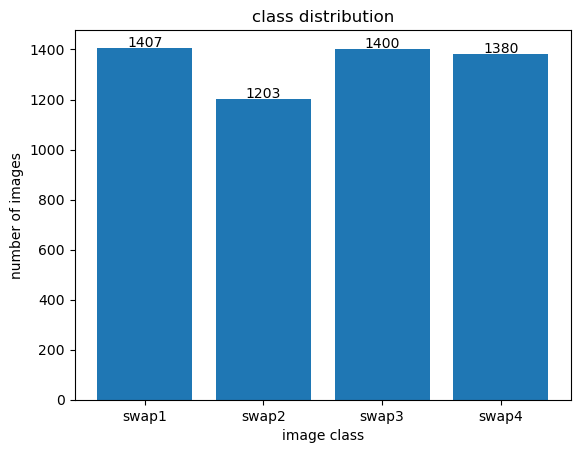

In [4]:
root = '/kaggle/input/nitrogen-deficiency-for-rice-crop/NitrogenDeficiencyImage/Training/'

def read_split_data(root, plot_image=False):
    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    assert os.path.exists(root), 'path does not exist!'

    classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    print(f'{len(df.labels.unique())} kind of images were found in the dataset')

    train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    train_image_path = train_df['filepaths'].tolist()
    val_image_path = test_df['filepaths'].tolist()

    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    val_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            ht += h
            wt += w
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('{} images were found in the dataset.\n{} to use for training, {} to use for validation'.format(
        sum(every_class_num), len(train_image_path), len(val_image_path)
    ))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center')
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, val_image_path, val_image_label, class_indices

train_image_path, train_image_label, val_image_path, val_image_label, class_indices = read_split_data(root, plot_image=True)

In [5]:
class MyDataset(Dataset):
    def __init__(self, image_path, image_labels, transforms=None):
        self.image_path = image_path
        self.image_labels = image_labels
        self.transform = transforms
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert('RGB')
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [6]:
data_transform = {
    'train': transforms.Compose([transforms.RandomResizedCrop(100), transforms.ToTensor(),
                                 transforms.RandomHorizontalFlip(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize((100, 100)), transforms.CenterCrop(100),
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

In [7]:
net = models.efficientnet_b4(pretrained=True).to(device)
net.classifier = nn.Sequential(nn.Dropout(0.5, inplace=True), 
                               nn.Linear(1792, 512, bias=False), nn.BatchNorm1d(512), 
                               nn.ReLU(inplace=True),
                               nn.Linear(512, 4)).to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [8]:
batch_size=16
lr=0.001
epochs=20
best_val_acc = 0.0
save_path='./EfficientNet_B4NO2Model.pth'
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)

train_dataset = MyDataset(train_image_path, train_image_label, data_transform['train'])
train_num = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, collate_fn=train_dataset.collate_fn)

valid_dataset = MyDataset(val_image_path, val_image_label, data_transform['valid'])
valid_num = len(valid_dataset)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                          collate_fn=valid_dataset.collate_fn)

In [9]:
train_Loss, train_Acc, val_Acc = [], [], []

for epoch in range(epochs):
    running_loss, train_acc, val_acc = 0, 0, 0
    
    net.train()
    train_bar = tqdm(train_loader, file=sys.stdout, colour='red')
    for step, data in enumerate(train_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        running_loss += loss.item()
        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        loss.backward()
        optimizer.step()
        train_bar.desc = f'train epoch [{epoch+1}/{epochs}] train_loss: {(loss.item()):.3f}'
        
    
    net.eval()
    with torch.no_grad():
        val_bar = tqdm(valid_loader, file=sys.stdout, colour='red')
        for data in val_bar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
            
    train_accuracy = train_acc / train_num
    val_accuracy = val_acc / valid_num
    train_loss = running_loss / train_num
    
    train_Loss.append(train_loss)
    train_Acc.append(train_accuracy)
    val_Acc.append(val_accuracy)
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(net.state_dict(), save_path)
        
    print(f'epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.3f}, train_accuracy: {train_accuracy:.3f}, valid_accuracy: {val_accuracy:.3f}')
    

print('Finish Training')

100%|██████████| 68/68 [00:03<00:00, 22.56it/s]
epoch [1/20], train_loss: 0.035, train_accuracy: 0.786, valid_accuracy: 0.904
100%|██████████| 68/68 [00:04<00:00, 15.71it/s]
epoch [2/20], train_loss: 0.018, train_accuracy: 0.897, valid_accuracy: 0.963
100%|██████████| 68/68 [00:02<00:00, 22.83it/s]
epoch [3/20], train_loss: 0.014, train_accuracy: 0.927, valid_accuracy: 0.973
100%|██████████| 68/68 [00:08<00:00,  8.15it/s]
epoch [4/20], train_loss: 0.013, train_accuracy: 0.932, valid_accuracy: 0.965
100%|██████████| 68/68 [00:05<00:00, 12.56it/s]
epoch [5/20], train_loss: 0.014, train_accuracy: 0.927, valid_accuracy: 0.947
100%|██████████| 68/68 [00:03<00:00, 19.75it/s]
epoch [6/20], train_loss: 0.012, train_accuracy: 0.938, valid_accuracy: 0.972
100%|██████████| 68/68 [00:03<00:00, 18.42it/s]
epoch [7/20], train_loss: 0.013, train_accuracy: 0.934, valid_accuracy: 0.896
100%|██████████| 68/68 [00:03<00:00, 22.17it/s]
epoch [8/20], train_loss: 0.011, train_accuracy: 0.945, valid_accuracy

In [10]:
# plt.figure(figsize=(8, 8))
# plt.title('Training Accuracy Loss and Validation Accuracy')
# plt.plot(train_Acc, label='train_accuracy')
# plt.plot(train_Loss, label='train_loss')
# plt.plot(val_Acc, label='valid_accuracy')
# plt.legend()
# plt.show()

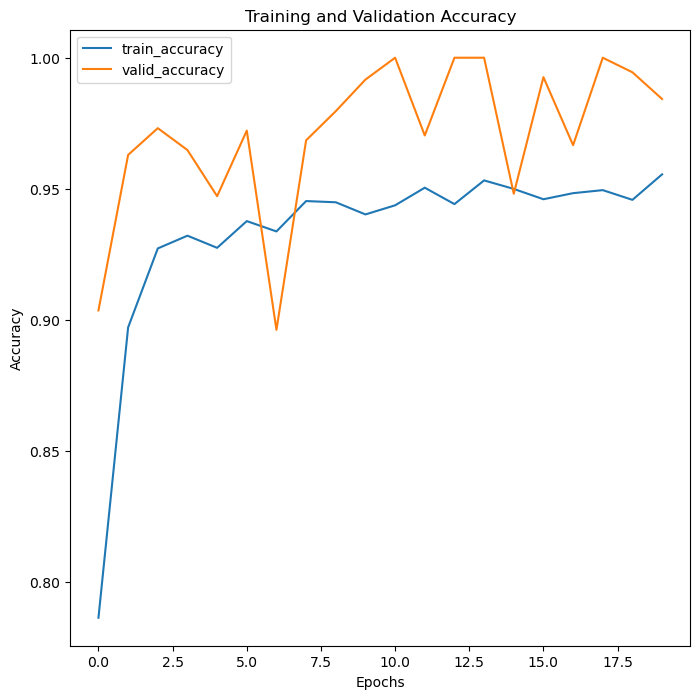

In [11]:
# plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(train_Acc, label='train_accuracy')
plt.plot(val_Acc, label='valid_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



there were 15 errors in 1078 tests for an accuracy of  98.61%
The F1-score was 98.609


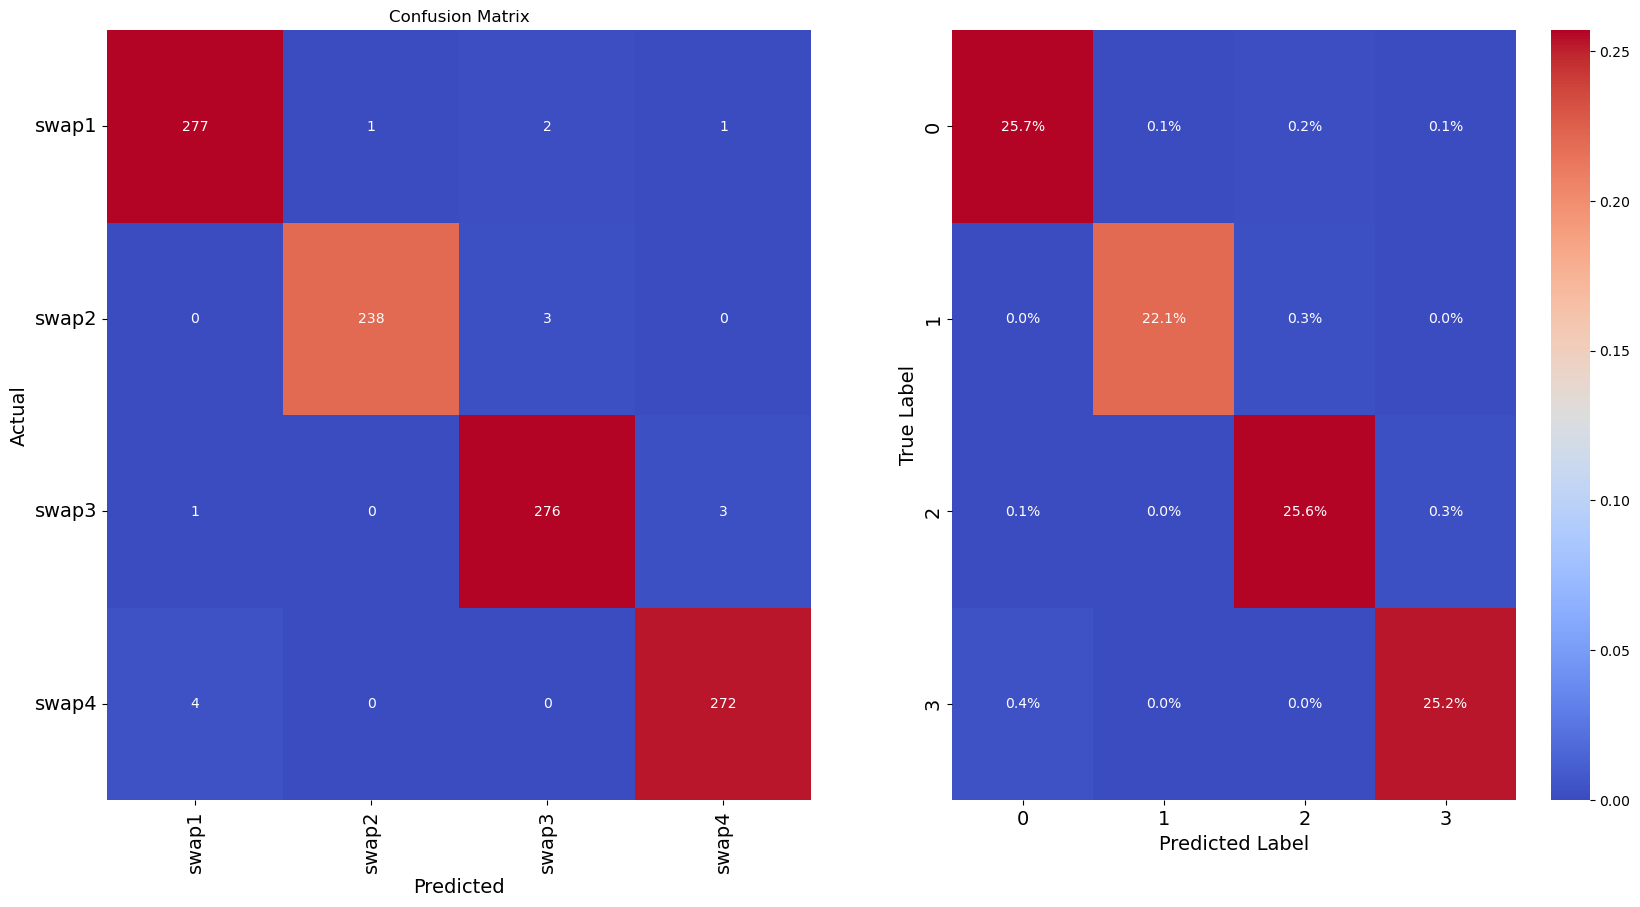

Classification Report:
----------------------
               precision    recall  f1-score   support

       swap1     0.9823    0.9858    0.9840       281
       swap2     0.9958    0.9876    0.9917       241
       swap3     0.9822    0.9857    0.9840       280
       swap4     0.9855    0.9855    0.9855       276

    accuracy                         0.9861      1078
   macro avg     0.9864    0.9861    0.9863      1078
weighted avg     0.9861    0.9861    0.9861      1078



In [12]:
try:
    json_file = open('./classes_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []
    
    assert os.path.exists(save_path)
    net.load_state_dict(torch.load(save_path))
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(torch.softmax(net(images), dim=0), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())
    
    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    print(f'The F1-score was {f1score:.3f}')
    
    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())
    
    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='coolwarm', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%', cmap='coolwarm')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)
    
    return f1score


f1score = predictor(valid_loader)

F1-score is 0.933 for train dataset while our holdout set is minutely higher at 0.938. This could be due to the amount of variations deriving from 4000plus images in the dataset vs 1000 in our holdout set. 

In [13]:
# Define a function to make predictions with the trained model
def predict(model, image_path):
    # Load the image and transform it to the appropriate format
    transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    # Make a prediction with the trained model
    model.eval()
    with torch.no_grad():
        output = model(image)
        class_index = torch.argmax(output, dim=1).item()

    # Map the predicted index to the class name
    class_names = ['class1', 'class2', 'class3', 'class4']
    class_name = class_names[class_index]

    return class_name




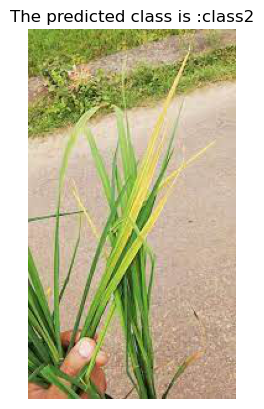

In [14]:
# Example usage: predict the class of a new image
image_path = "/kaggle/input/rice-leaf-test/googleimage1.jpg"
class_name = predict(net, image_path)
image_show = Image.open(image_path)
plt.imshow(image_show)
plt.title('The predicted class is :' + class_name)
plt.axis('off')
plt.show()

In [15]:
import pickle
pickle.dump(save_path, open("NO2_model.sav", 'wb'))

In [16]:
pip freeze > requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
